<a href="https://colab.research.google.com/github/majavk/Data_Science_Portfolio/blob/main/gradient_boosting_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ENSEMBLE Machine Learning - Gradeint Boosting Regression

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.util.testing as tm
import seaborn as sns

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

import warnings
import xgboost
from xgboost import XGBRegressor

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Features

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/udemy_tensorflow/1st_lecture/FINAL_TF2_FILES/TF_2_Notebooks_and_Data/03-ANNs/portfolio_example_regression/housing prices/'

In [ ]:
df_train = pd.read_csv(path + 'train_features.csv')
df_test = pd.read_csv(path + 'test_features.csv')


In [ ]:
X = df_train.drop('SalePrice', axis=1)
y = df_train['SalePrice'].values.reshape(-1,1)
X_test = df_test


#Building a model

In [ ]:
X_train, X_validate, y_train,  y_validate = train_test_split(X, y, test_size=0.2, random_state=101)
X_train.shape


(1165, 50)

In [ ]:
scalerX = preprocessing.RobustScaler()
scalerX.fit(X_train)


RobustScaler()

In [ ]:
X_train_scaled = scalerX.transform(X_train)
X_validate_scaled = scalerX.transform(X_validate)
X_test_scaled = scalerX.transform(X_test)


##Gradient Boosting Regressor

###Optimization of parameters

In [ ]:
GBR = GradientBoostingRegressor()
param_grid = {'learning_rate': [0.1,0.05,0.2], 'n_estimators': [50,100], 'max_depth' : [3,4,5,8]}

Grid_g = GridSearchCV(GBR, param_grid, cv=4, n_jobs=4)
Grid_g.fit(X_train_scaled, y_train)
BestGBR = Grid_g.best_estimator_

BestGBR

GradientBoostingRegressor(learning_rate=0.2)

In [ ]:
BestGBR.fit(X_train_scaled, y_train)
BestGBR_rmse = mean_squared_error(y_train, BestGBR.predict(X_train_scaled))
print(f"Gradient Boosting Regressor GBR RMSE:{BestGBR_rmse:.15f}")
BestGBR_mabser = mean_absolute_error(y_train, BestGBR.predict(X_train_scaled))
print(f"Gradient Boosting Regressor GBR RMSE:{BestGBR_mabser:.15f}")
Best_GBR_r2 = metrics.r2_score(y_train, BestGBR.predict(X_train_scaled))
print(f"Gradient Boosting Regressor GBR R2:{Best_GBR_r2:.15f}")

BestGBR_rmse_val = mean_squared_error(y_validate, BestGBR.predict(X_validate_scaled))
print(f"Gradient Boosting Regressor RMSE_VAL:{BestGBR_rmse_val:.15f}")
BestGBR_mabser_val = mean_absolute_error(y_validate, BestGBR.predict(X_validate_scaled))
print(f"Gradient Boosting Regressor RMSE_VAL:{BestGBR_mabser_val:.15f}")
Best_GBR_r2_val = metrics.r2_score(y_validate, BestGBR.predict(X_validate_scaled))
print(f"Gradient Boosting Regressor R2_VAL:{Best_GBR_r2_val:.15f}")


Gradient Boosting Regressor GBR RMSE:109174173.062265634536743
Gradient Boosting Regressor GBR RMSE:8075.584347808188795
Gradient Boosting Regressor GBR R2:0.982963971866437
Gradient Boosting Regressor RMSE_VAL:705401863.681623458862305
Gradient Boosting Regressor RMSE_VAL:17352.969753385401418
Gradient Boosting Regressor R2_VAL:0.881632014407622


###Explained variance by the model

In [ ]:
scores = cross_val_score(BestGBR, X_train_scaled, y_train, scoring='r2', cv=10)	
print(scores)


[0.94654804 0.92493378 0.9106352  0.88884174 0.91281758 0.90388064
 0.88643682 0.84343353 0.86463523 0.87826553]


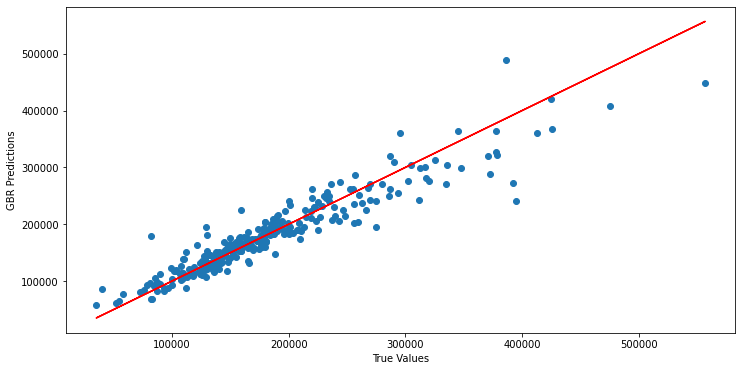

In [ ]:
plt.figure(figsize=(12,6))
predictions = BestGBR.fit(X_train_scaled, y_train).predict(X_validate_scaled)
plt.scatter(y_validate, predictions)
plt.xlabel('True Values')
plt.ylabel('GBR Predictions')
plt.plot(y_validate, y_validate, 'r')
plt.show()

###Importance of the features

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

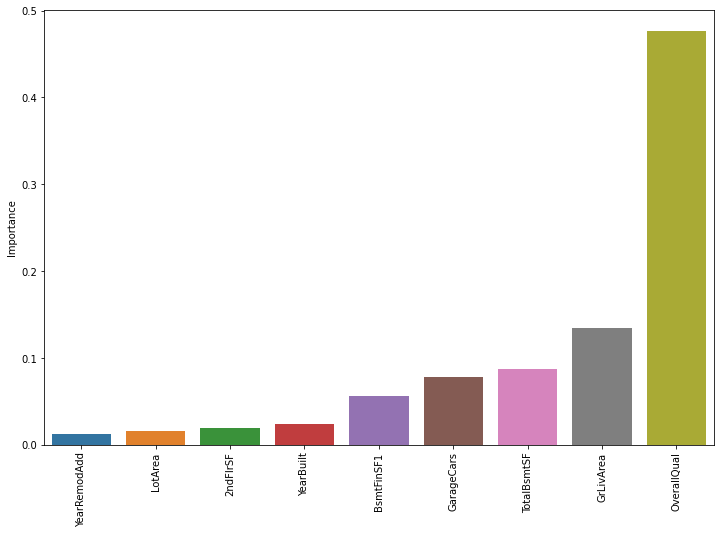

In [ ]:
feature_import = BestGBR.feature_importances_
imp_feat = pd.DataFrame(index=X_train.columns,
                        data=feature_import,
                        columns=['Importance'])
imp_feat = imp_feat[imp_feat['Importance'] > 0.01]
imp_feat = imp_feat.sort_values('Importance')
plt.figure(figsize=(12,8))
sns.barplot(data=imp_feat,
            x=imp_feat.index,
            y='Importance')
plt.xticks(rotation=90)

In [ ]:
imp_feat.index

Index(['YearRemodAdd', 'LotArea', '2ndFlrSF', 'YearBuilt', 'BsmtFinSF1',
       'GarageCars', 'TotalBsmtSF', 'GrLivArea', 'OverallQual'],
      dtype='object')

#Extreme Boosting Regressor

###Optimization of parameters

In [ ]:
xGBR = XGBRegressor()
param_grid = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0], 'n_estimators': [100, 200, 500], 'min_samples_leaf':[3], 'max_depth' : [4,6,8, 16,32]}

Grid10 = GridSearchCV(xGBR, param_grid, cv=5, n_jobs=4)
Grid10.fit(X_train_scaled, y_train)
BestxGBR = Grid10.best_estimator_

BestxGBR

[16:36:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=4, min_samples_leaf=3, n_estimators=200)

###Explained variance by the model

In [ ]:
BestxGBR.fit(X_train_scaled, y_train)
BestxGBR_rmse = mean_squared_error(y_train, BestxGBR.predict(X_train_scaled))
print(f"xGBR RMSE:{BestxGBR_rmse:.15f}")
BestxGBR_mabser = mean_absolute_error(y_train, BestxGBR.predict(X_train_scaled))
print(f"xGBR RMSE:{BestxGBR_mabser:.15f}")
Best_xGBR_r2 = metrics.r2_score(y_train, BestxGBR.predict(X_train_scaled))
print(f"xGBR R2:{Best_xGBR_r2:.15f}")

BestxGBR_rmse_val = mean_squared_error(y_validate, BestxGBR.predict(X_validate_scaled))
print(f"xGBR RMSE_VAL:{BestxGBR_rmse_val:.15f}")
BestxGBR_mabser_val = mean_absolute_error(y_validate, BestxGBR.predict(X_validate_scaled))
print(f"xGBR RMSE_VAL:{BestxGBR_mabser_val:.15f}")
Best_xGBR_r2_val = metrics.r2_score(y_validate, BestxGBR.predict(X_validate_scaled))
print(f"xGBR R2_VAL:{Best_xGBR_r2_val:.15f}")

[12:53:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xGBR RMSE:16.486966859219923
xGBR RMSE:2.367130498927039
xGBR R2:0.999999997427300
xGBR RMSE_VAL:643493360.704181790351868
xGBR RMSE_VAL:17522.360445205478754
xGBR R2_VAL:0.892020397492171


In [ ]:
scores_xGBR = cross_val_score(BestxGBR, X_train_scaled, y_train, scoring='r2', cv=10)

print(scores_xGBR)

[09:39:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[12:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


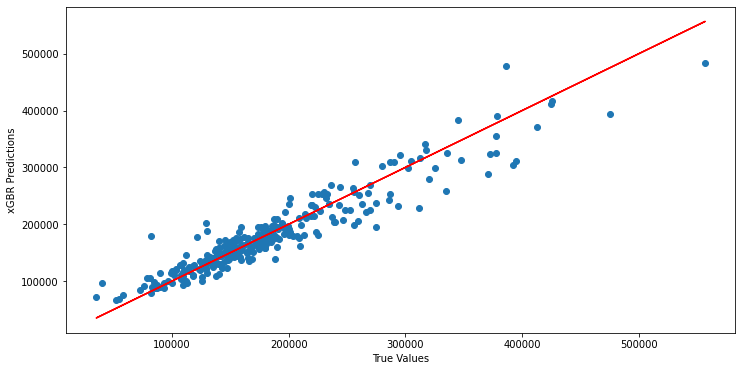

In [ ]:
plt.figure(figsize=(12,6))
predictions = BestxGBR.fit(X_train_scaled, y_train).predict(X_validate_scaled)
plt.scatter(y_validate, predictions)
plt.xlabel('True Values')
plt.ylabel('xGBR Predictions')
plt.plot(y_validate, y_validate, 'r')

###Importance of the features

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

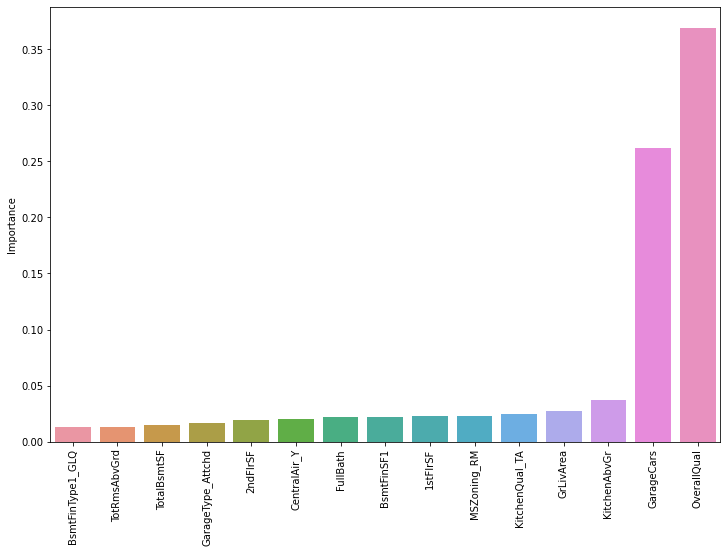

In [ ]:
feature_import = BestxGBR.feature_importances_
imp_feat = pd.DataFrame(index=X_train.columns,
                        data=feature_import,
                        columns=['Importance'])
imp_feat = imp_feat[imp_feat['Importance'] > 0.01]
imp_feat = imp_feat.sort_values('Importance')
plt.figure(figsize=(12,8))
sns.barplot(data=imp_feat,
            x=imp_feat.index,
            y='Importance')
plt.xticks(rotation=90)

#Conclusion

xGBR gave better results then the GBR model.
Both gradient boosting regressors are giving good fit to this model and are explaining about the 90% of the variance of the data.